In [1]:
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
import scvelo as scv
import scanpy as sc
import celldancer.utilities as cdutil
import numpy as np
import seaborn as sns

In [2]:
adata = scv.datasets.dentategyrus()

In [3]:
adata = adata[~adata.obs["clusters"].isin(["Cajal Retzius", "GABA", "OPC", "OL", "Microglia", "Endothelial"]), :]

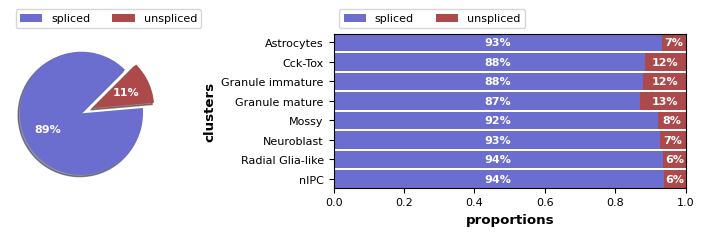

In [4]:
scv.pl.proportions(adata, groupby = "clusters")

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 10691 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
cdutil.adata_to_df_with_embed(adata,
                              us_para = ['Mu','Ms'],
                              cell_type_para = 'clusters',
                              embed_para = 'X_umap',
                              save_path = 'celldancer_predata.csv')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 149.68it/s]


,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Tcea1,0.110726,0.087689,AAACATACCCATGA,Granule immature,2.731375,-8.038435
1,Tcea1,0.107307,0.690268,AAACATACCGTAGT,Radial Glia-like,-1.500444,10.311057
2,Tcea1,0.099151,0.095875,AAACATACGAGAGC,Granule mature,1.577865,-11.268647
3,Tcea1,0.028187,0.037078,AAACATACTGAGGG,Granule immature,-1.202822,-1.029693
4,Tcea1,0.120354,0.065606,AAACATTGGCATCA,Granule immature,2.382317,-8.879890
...,...,...,...,...,...,...,...
5127995,Kdm5d,0.000000,0.000000,TTTCTACTGAACTC,nIPC,-2.192029,7.180995
5127996,Kdm5d,0.000000,0.021801,TTTCTACTTCCCGT,Granule immature,1.149485,-2.563402
5127997,Kdm5d,0.000000,0.000000,TTTGACTGCCTGTC,Neuroblast,-3.285519,2.465202
5127998,Kdm5d,0.000000,0.012282,TTTGACTGTCTGGA,Granule mature,0.024807,-8.033849


In [7]:
cell_type_u_s = pd.read_csv('celldancer_predata.csv')

In [8]:
loss_df, cellDancer_df = cd.velocity(cell_type_u_s, permutation_ratio = 0.125, n_jobs = 16)

Using /media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/dentategyrus/main_branch/cellDancer_velocity_2024-05-20 19-55-24 as the output path.
Arranging genes for parallel job.
2000  genes were arranged to  125  portions.



Velocity Estimation: 100%|██████████| 125/125 [05:13<00:00,  2.58s/it]                                                                           
                                                                                                                                                 

In [3]:
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=200)

Caution! Overwriting the 'velocity' columns.


In [4]:
cellDancer_df.to_csv("data/celldancer_result.csv")

In [5]:
adata_celldancer = cdutil.to_dynamo(cellDancer_df)

In [6]:
adata_celldancer

AnnData object with n_obs × n_vars = 2564 × 2000
    obs: 'clusters'
    var: 'highly_variable_genes', 'loss', 'use_for_dynamics', 'use_for_transition'
    uns: 'dynamics'
    obsm: 'X_cdr', 'velocity_cdr'
    layers: 'X_spliced', 'X_unspliced', 'M_s', 'M_u', 'velocity_S', 'velocity_U', 'alpha', 'beta', 'gamma'
    obsp: 'connectivities', 'distances'

In [7]:
adata_celldancer.write_h5ad("data/celldancer.h5ad")